In [ ]:
!pip install opencv-python
!pip install tqdm
!pip install tensorflow
!pip install matplotlib
!pip install tflearn

! pip uninstall tensorflow
! pip install tensorflow==1.14

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
TRAIN_DIR=r"D:\train"
TEST_DIR=r"D:\test"
IMG_SIZE=50
LR=1e-3
MODEL_NAME='dogs-vs-cats-convnet'

In [4]:
def label_img(img):
    word_label=img.split('.')[-3]
    if word_label=='cat':return[1,0]
    elif word_label=='dog':return[0,1]

In [11]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data, allow_pickle=True)  # 修改部分
    return training_data

In [12]:
def create_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data, allow_pickle=True)  # 修改部分
    return testing_data

In [13]:
train_data = create_train_data()
test_data = create_test_data()

100%|██████████| 11941/11941 [00:36<00:00, 325.95it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (11941, 2) + inhomogeneous part.

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Scipy not supported!


In [8]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')

convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_dir = 'log', tensorboard_verbose = 0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\ocean\dogs-vs-cats-convnet
model loaded!


In [10]:
train = train_data[:-8000]
test = train_data[-8000:]

In [16]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [17]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5,
          validation_set=({'input': test_x}, {'targets': test_y}),
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 619  | total loss: 0.33548 | time: 6.198s
| Adam | epoch: 010 | loss: 0.33548 - acc: 0.8623 -- iter: 3904/3941
Training Step: 620  | total loss: 0.35184 | time: 9.562s
| Adam | epoch: 010 | loss: 0.35184 - acc: 0.8557 | val_loss: 0.68775 - val_acc: 0.7093 -- iter: 3941/3941
--


In [18]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\ocean\dogs-vs-cats-convnet is not in all_model_checkpoint_paths. Manually adding it.


Cat Possibility: 26.85%
Dog Possibility: 73.15%


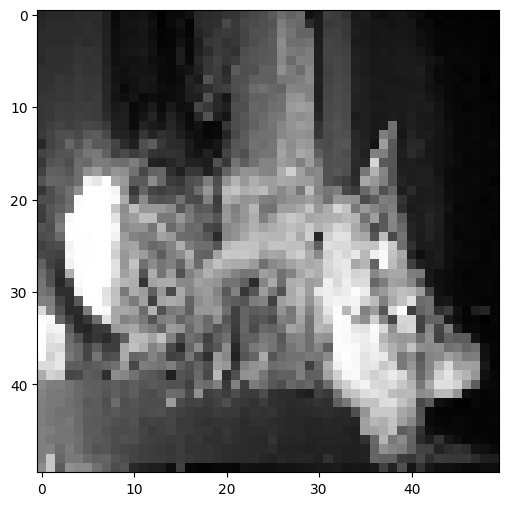

In [19]:
d = test_data[0]
img_data, img_num = d
data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap = 'gray')

print('Cat Possibility: {:5.2f}%\nDog Possibility: {:5.2F}%'. format(prediction[0]*100, prediction[1]*100))

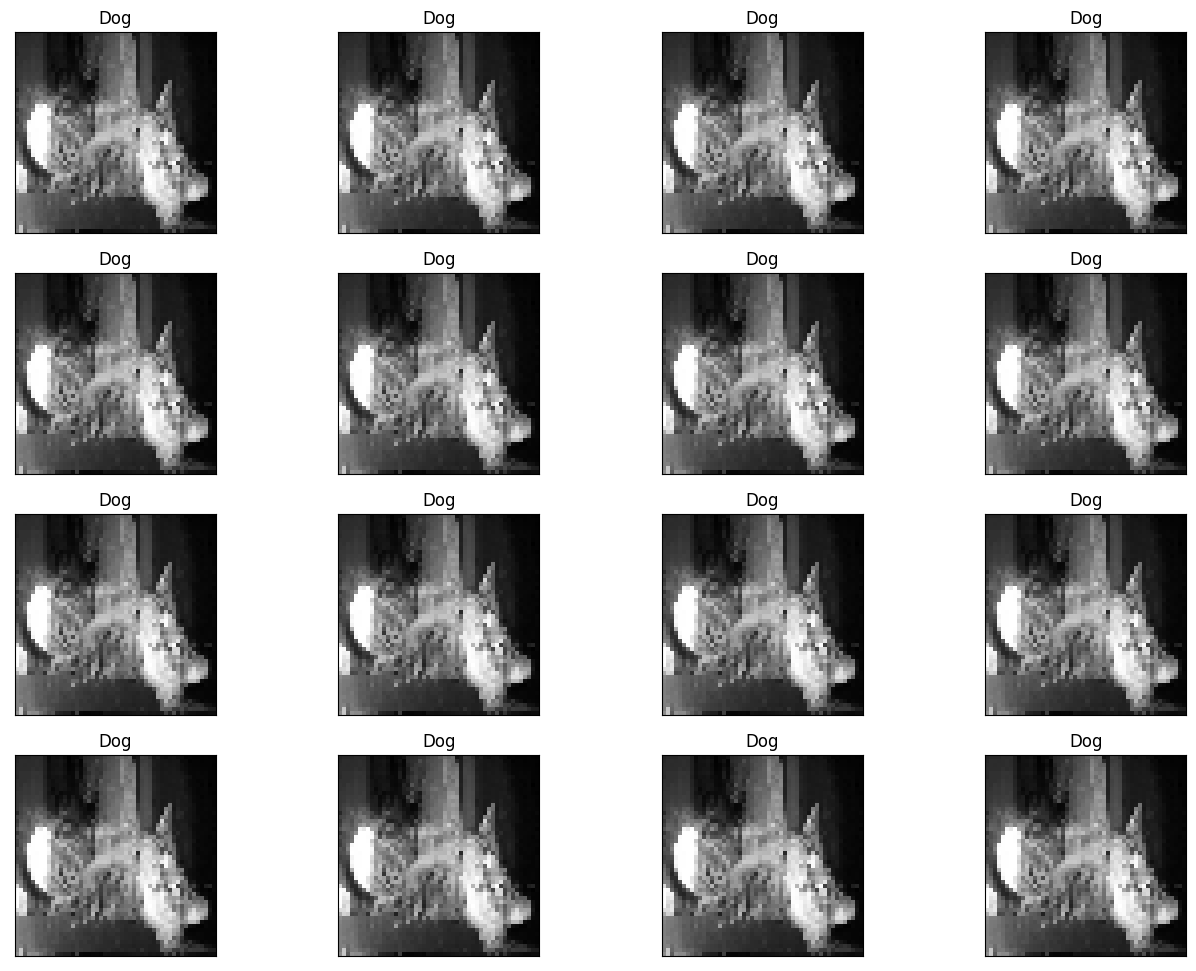

In [20]:
fig = plt.figure(figsize = (16,12))
for num, data in enumerate(test_data[:16]):
    img_num = data[1]
    img_num = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()